In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.6 MB/s eta 0:00:00


#Importando todas as bibliotecas necessárias para o projeto

In [89]:
import pandas as pd
import numpy as np
import os
import kagglehub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna
import warnings
import seaborn as sns

#Instalando o dataset do kaggle que será utilizado

In [3]:
path = kagglehub.dataset_download("juice0lover/users-vs-bots-classification")

print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 110k/110k [00:00<00:00, 19.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/juice0lover/users-vs-bots-classification/versions/3
['bots_vs_users.csv']


Este dataset contém dados de perfis do VK.com (maior rede social da Rússia), utilizados para identificar se um usuário é um ser humano ou um bot. Ele inclui **5874 registros** com **60 features** (numéricas e categóricas), distribuídos igualmente entre humanos e bots (50/50).

- **Features numéricas:** métricas de atividade (ex: média de posts por semana, número de amigos), com valores ausentes como `NaN`.
- **Features categóricas:** atributos de perfil e configurações de privacidade (ex: `has_photo`, `is_closed_profile`), com valores ausentes preenchidos como `'unknown'`.
- **Valores booleanos:** convertidos para `0` ou `1`.

Esse dataset será utilizado para classificarmos se um usuário é ser humano ou um bot.

In [4]:
df = pd.read_csv(os.path.join(path, "bots_vs_users.csv"))
df

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,0.0,Unknown,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,0.0,1.0,Unknown
5870,1.0,Unknown,1.0,0.0,0.0,Unknown,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,Unknown
5871,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,Unknown
5872,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Moscow,1.0,0.0,1.0,Unknown


#Início do tratamento de dados

Primeiramente, averiguamos que todos os valores estão no tipo numérico(int ou float),exceto no atributo 'city',convertendo eles e se não for possível ele recebe como valor NaN(nulo)

In [5]:
int_cols = [col for col in df.columns if col != 'city']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
df

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,0.0,NaN,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,0.0,1.0,NaN
5870,1.0,NaN,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,NaN
5871,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,NaN
5872,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Moscow,1.0,0.0,1.0,NaN


Aqui é analisado a correlação existente entre as variáveis para ver possiveis caminhos para manipular o dataset


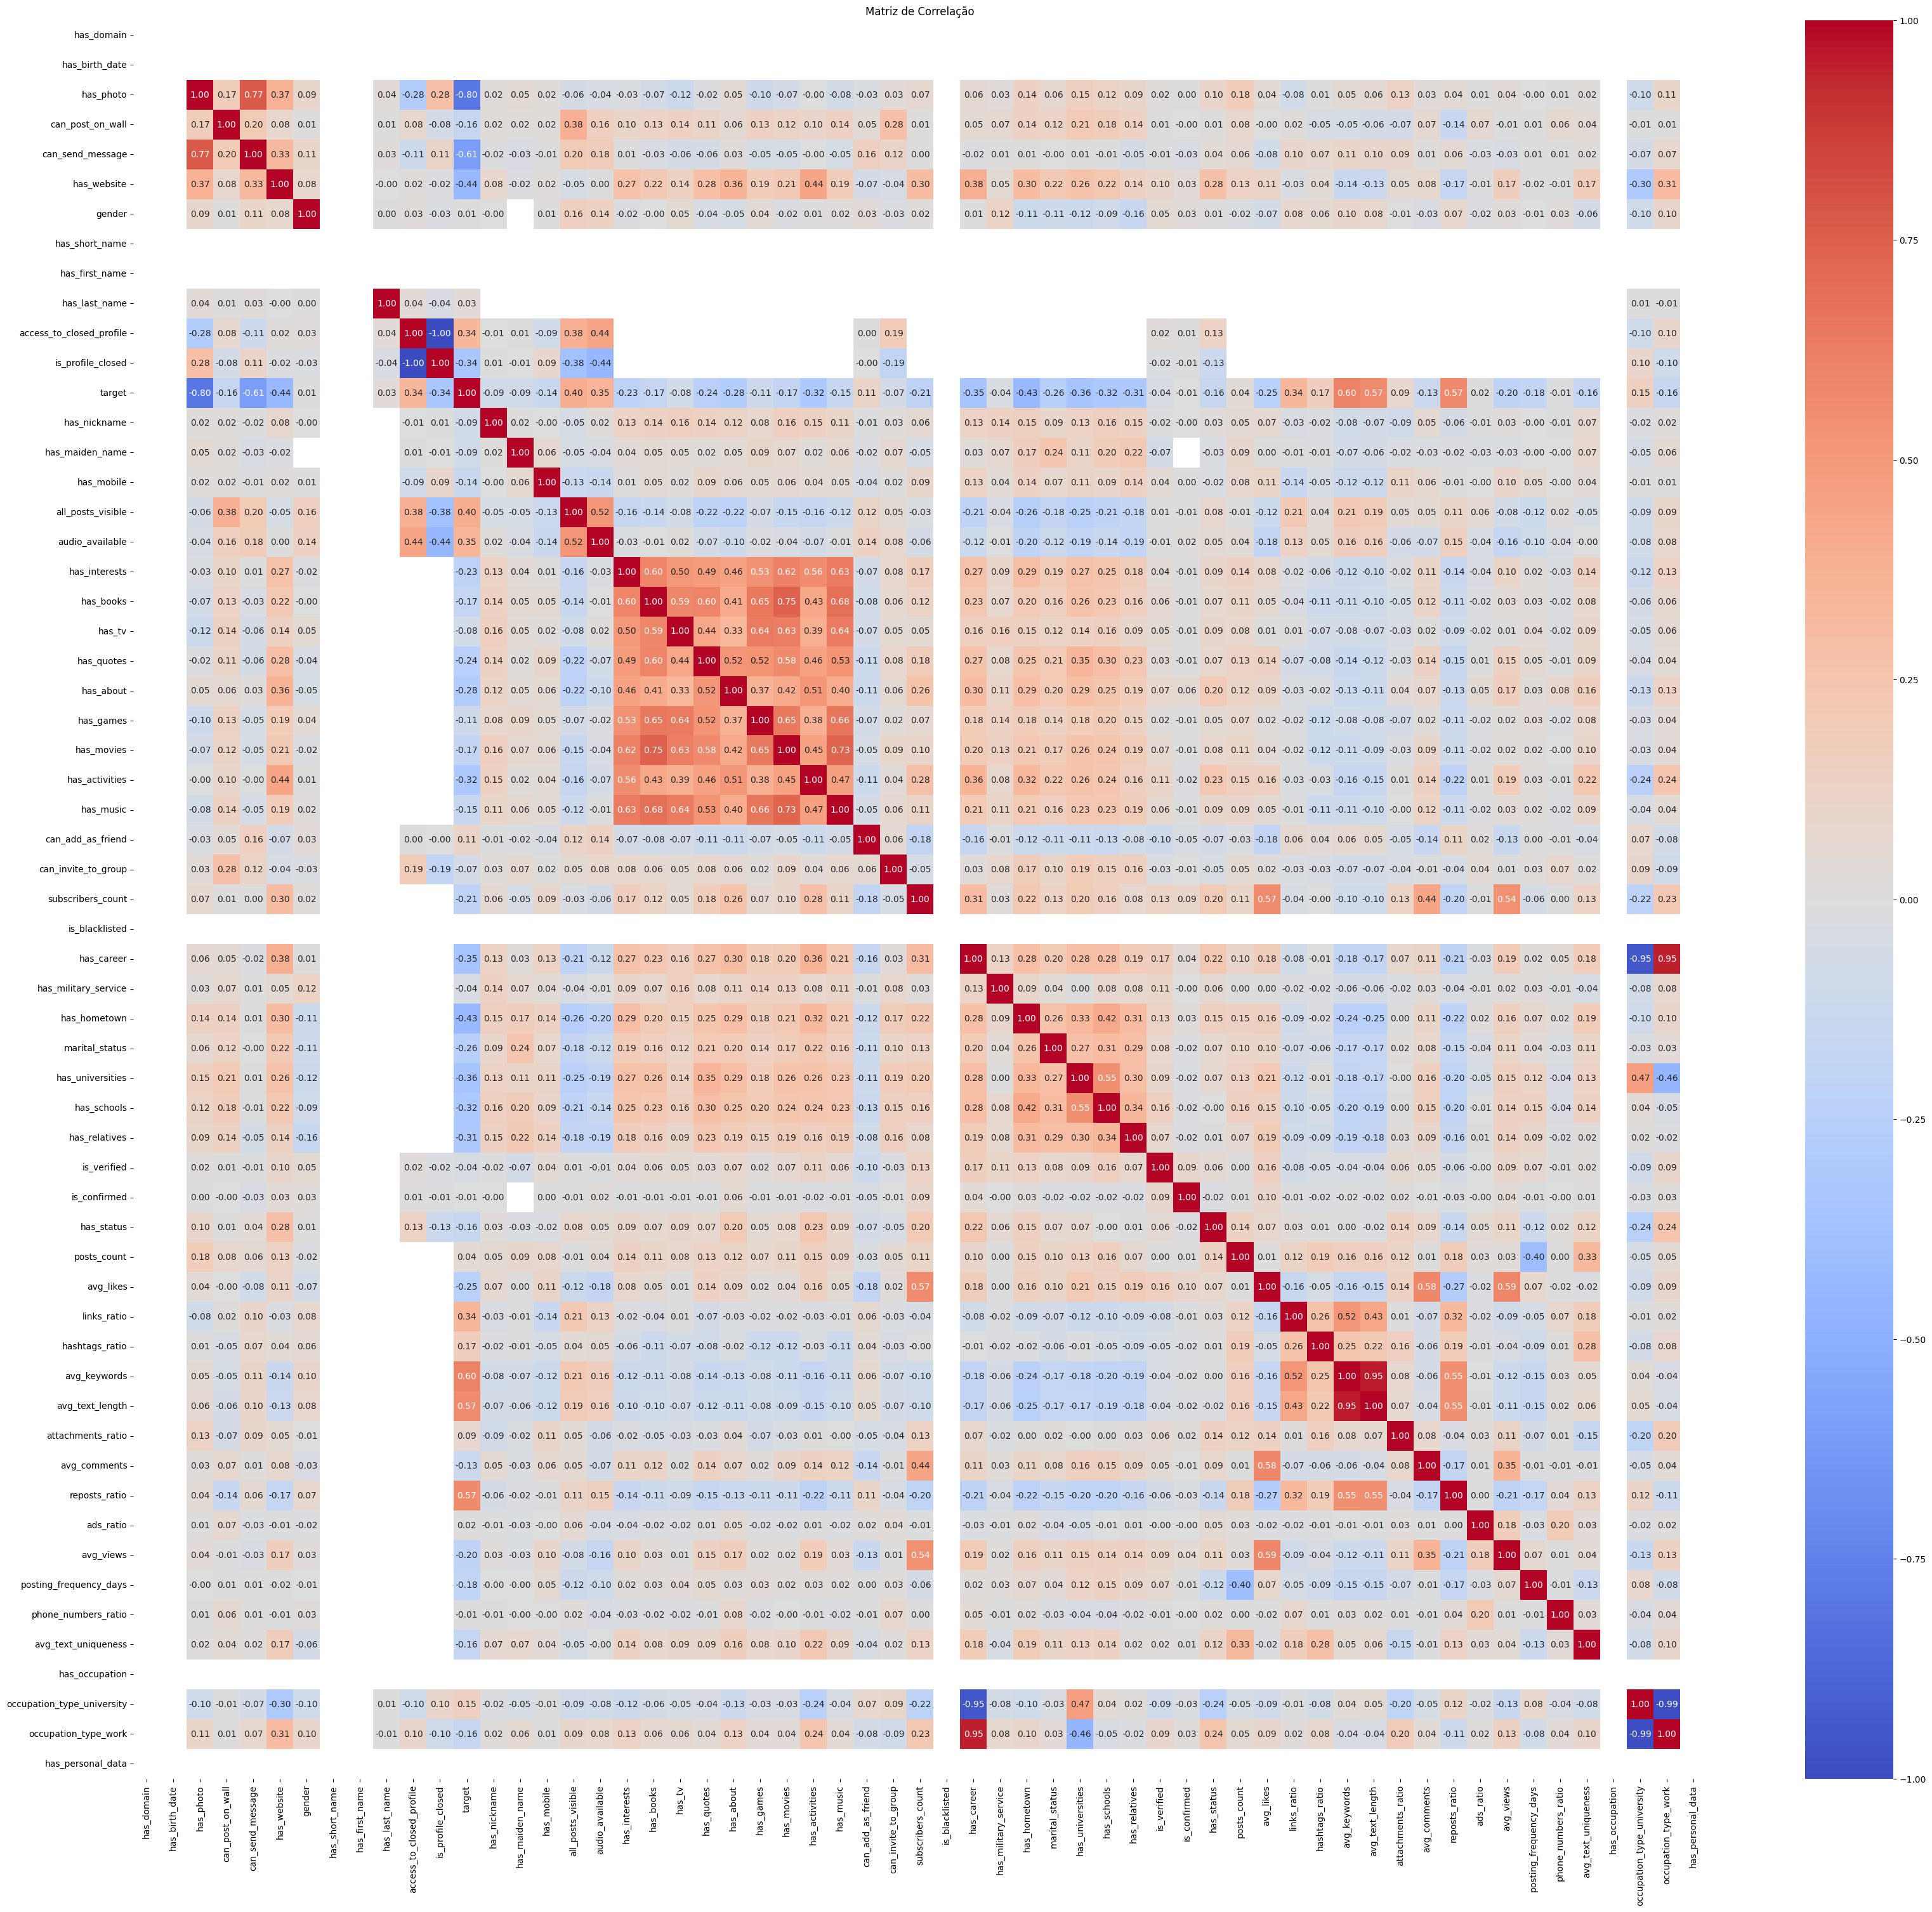

In [7]:
correlacao = df[int_cols].corr()

plt.figure(figsize=(40, 36))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")

plt.savefig("matriz_correlacao.png", dpi=300, bbox_inches='tight')

plt.show()

In [8]:
print("melhores valores de correlacao:0.95 para has_career e occupation_type_university e 0.99 para occupation_type_university e occupation_type_work")
# Verifica valores nulos em has_career
filtro_career = df['has_career'].isnull()
linhas_career = df[filtro_career]
quantidade_career = filtro_career.sum()
print(f"Linhas com valor nulo em has_career: {quantidade_career}")

# Verifica valores nulos em occupation_type_university
filtro_uni = df['occupation_type_university'].isnull()
linhas_uni = df[filtro_uni]
quantidade_uni = filtro_uni.sum()
print(f"Linhas com valor nulo em occupation_type_university: {quantidade_uni}")

# Verifica nulo em ambas: has_career e occupation_type_university
filtro_ambas = filtro_career & filtro_uni
linhas_ambas = df[filtro_ambas]
quantidade_ambas = filtro_ambas.sum()
print(f"Linhas com valor nulo em ambas (has_career e occupation_type_university): {quantidade_ambas}")

# Verifica valores nulos em occupation_type_work
filtro_work = df['occupation_type_work'].isnull()
linhas_work = df[filtro_work]
quantidade_work = filtro_work.sum()
print(f"Linhas com valor nulo em occupation_type_work: {quantidade_work}")


melhores valores de correlacao:0.95 para has_career e occupation_type_university e 0.99 para occupation_type_university e occupation_type_work
Linhas com valor nulo em has_career: 4601
Linhas com valor nulo em occupation_type_university: 3497
Linhas com valor nulo em ambas (has_career e occupation_type_university): 2888
Linhas com valor nulo em occupation_type_work: 3497


In [9]:
print("correlacao acima de 0.68")
# Verifica valores nulos em has_movie
filtro_movie = df['has_movies'].isnull()
linhas_movie = df[filtro_movie]
quantidade_movie = filtro_movie.sum()
print(f"Linhas com valor nulo em has_movies: {quantidade_movie}")

# Verifica valores nulos em has_book
filtro_book = df['has_books'].isnull()
linhas_book = df[filtro_book]
quantidade_book = filtro_book.sum()
print(f"Linhas com valor nulo em has_books: {quantidade_book}")

# Verifica valores nulos em has_music
filtro_music = df['has_music'].isnull()
linhas_music = df[filtro_music]
quantidade_music = filtro_music.sum()
print(f"Linhas com valor nulo em has_music: {quantidade_music}")

# Verifica valores nulos em todas as três colunas ao mesmo tempo
filtro_todos = filtro_movie & filtro_book & filtro_music
linhas_todos = df[filtro_todos]
quantidade_todos = filtro_todos.sum()
print(f"Linhas com valor nulo em todas (has_movie, has_book e has_music): {quantidade_todos}")


correlacao acima de 0.68
Linhas com valor nulo em has_movies: 4601
Linhas com valor nulo em has_books: 4601
Linhas com valor nulo em has_music: 4601
Linhas com valor nulo em todas (has_movie, has_book e has_music): 4601


Assim,vemos que nos valores onde temos melhores indíces de correlação, tambem é verificado uma grande ausencia de dados nos atributos correlacionados, dificultando uma inputação com base nessa característica

In [10]:
print("correlacao de 0.77")
# Verifica valores nulos em has_photo
filtro_photo = df['has_photo'].isnull()
linhas_photo = df[filtro_photo]
quantidade_photo = filtro_photo.sum()
print(f"Linhas com valor nulo em has_photo: {quantidade_photo}")

# Verifica valores nulos em can_send_mensage
filtro_message = df['can_send_message'].isnull()
linhas_message = df[filtro_message]
quantidade_message = filtro_message.sum()
print(f"Linhas com valor nulo em can_send_mensage: {quantidade_message}")

# Verifica valores nulos em ambas: has_photo e can_send_mensage
filtro_ambas = filtro_photo & filtro_message
linhas_ambas = df[filtro_ambas]
quantidade_ambas = filtro_ambas.sum()
print(f"Linhas com valor nulo em ambas (has_photo e can_send_mensage): {quantidade_ambas}")


correlacao de 0.77
Linhas com valor nulo em has_photo: 24
Linhas com valor nulo em can_send_mensage: 24
Linhas com valor nulo em ambas (has_photo e can_send_mensage): 24


E nesse caso com outra correlação alta,não há muitos valores faltantes e as linhas que tem um atributo como nulo,acaba tendo o outro tambem como nulo

Nessa parte dividimos os atributos do dataset em 3 porções,de acordo com a quantidade de valores nulos em cada atributo

In [11]:
null_percent = df.isna().mean() * 100

low_nulls = null_percent[null_percent <= 10].sort_values()
mid_nulls = null_percent[(null_percent > 10) & (null_percent <= 50)].sort_values()
high_nulls = null_percent[null_percent > 50].sort_values()

Para o caso em que o atributo conta com mais de 50% dos seus valores faltando,retiramos essa coluna do dataset

In [12]:
high_nulls

,0
has_status,50.459653
subscribers_count,55.737147
has_maiden_name,58.154580
has_occupation,59.533538
occupation_type_university,59.533538
occupation_type_work,59.533538
reposts_ratio,76.319374
phone_numbers_ratio,76.319374
avg_text_length,76.319374
attachments_ratio,76.319374


In [13]:
columns_high_nulls = ["has_status", "subscribers_count", "has_maiden_name", "has_occupation", "occupation_type_university", "occupation_type_work", "reposts_ratio", "phone_numbers_ratio",
           "avg_text_length", "attachments_ratio", "avg_keywords", "hashtags_ratio", "avg_likes", "avg_comments", "avg_views", "posting_frequency_days", "avg_text_uniqueness",
           "links_ratio", "posts_count", "ads_ratio", "has_universities", "marital_status", "has_hometown", "has_military_service", "has_tv", "has_games", "has_about",
           "has_quotes", "has_career", "has_music", "has_activities", "has_movies", "has_schools", "has_relatives", "has_books", "has_interests", "has_personal_data"]
len(columns_high_nulls)

df = df.drop(columns=columns_high_nulls)

Para os atributos com menos de 10% de dados faltando, os dados que faltam completamos com 0 e criamos uma nova coluna, referente a se aquele dado estava faltando ou não

In [14]:
low_nulls

,0
target,0.00000
city,0.00000
has_domain,0.40858
has_photo,0.40858
gender,0.40858
has_short_name,0.40858
can_post_on_wall,0.40858
can_send_message,0.40858
has_last_name,0.40858
has_first_name,0.40858


In [15]:
for col in low_nulls.index:
    df[col+'_missing'] = df[col].isna().astype('int')
    df[col] = df[col].fillna(0.0)

No caso do mid_nulls(entre 10% e 50% dos dados faltando) completamos os valores faltantes com a média dos dados daquele atributo

In [16]:
mid_nulls

,0
has_website,12.631937
has_birth_date,14.572693
has_nickname,43.513790
has_mobile,43.513790
all_posts_visible,43.513790
audio_available,43.513790
can_add_as_friend,43.513790
can_invite_to_group,43.513790
is_blacklisted,43.513790
is_verified,43.513790


In [17]:
for col in mid_nulls.index:
      df[col].fillna(df[col].mean(), inplace=True)

<ipython-input-17-0c37db7594fa>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Nessa parte, primeiro é retirado as linhas que tem valores iguais,após isso é removido qualquer coluna que seus valores sejam todos iguais(constantes) e por último reiniciamos o index da tabela para melhor visualização

In [18]:
df = df.drop_duplicates()#elimina as linhas com valores duplicados

#verifica se há colunas com valores constantes,se tiver, retira elas do dataset
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=constant_cols)

df = df.reset_index(drop=True)#reinicia o index após todas as modificacoes

Como "city" tem como valor uma string, o modelo não consegue receber os dados nesse tipo, então é necessário modificar. Para isso, é selecionado as 10 cidades mais frequentes e o resto delas é nomeado como "other". Cada uma dessas 10 cidades se torna uma coluna que com valores de 1 ou 0 e há a coluna "other" para quando uma cidade não era uma do top 10, por último, a coluna original 'city' é excluída.

In [19]:
top_cities = df['city'][df['city'] != 'Unknown'].value_counts().nlargest(10).index
df['city_grouped'] = df['city'].apply(lambda x: x if x in top_cities else 'Other')
df = pd.get_dummies(df, columns=['city_grouped'], drop_first=True)
df = df.drop(columns=['city'])

In [20]:
df

,has_domain,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,access_to_closed_profile,...,city_grouped_Kostomuksha,city_grouped_Krasnodar,city_grouped_Moscow,city_grouped_Murmansk,city_grouped_New York City,city_grouped_Nizhny Novgorod,city_grouped_Other,city_grouped_Perm,city_grouped_Petrozavodsk,city_grouped_Saint Petersburg
0,1.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
1,1.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2,1.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,0.0,...,False,False,False,False,False,False,True,False,False,False
3,1.0,1.0,0.0,1.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
4,1.0,1.0,0.0,1.0,0.13562,1.0,1.0,1.0,1.0,0.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,1.0,1.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,True
1310,1.0,1.0,0.0,1.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
1311,1.0,1.0,0.0,1.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
1312,1.0,1.0,0.0,1.0,1.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False


#Separação da base em treino e teste
Nessa etapa é separado a porção de treino e a porção de teste. Usamos parâmetro  stratify para garantir que os conjuntos vão manter a mesma
distribuição de classes

In [21]:
#Target and train arrays
X = df.drop('target', axis=1)
y = df['target']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Início da criação dos modelos,primeiramente sem camadas ocultas

A partir daqui é seguido sempre um padrão em busca do melhor modelo. Iremos ir acrescendo neurônios e/ou camadas em busca de uma rede com melhores resultados. Será utilizado uma rede densa e como optimizador o SGD sem momentum para o início, será feito o treinamento e plotado os gráficos para poder ser visto a evolução das métricas no período de treino e validação

In [23]:
model_no_hidden_layer = Sequential()
model_no_hidden_layer.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))

opt = SGD(learning_rate=0.01)
model_no_hidden_layer.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
historico1 = model_no_hidden_layer.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose = 0)

In [25]:
train_loss, train_accuracy = model_no_hidden_layer.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_no_hidden_layer.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.4276 | Acurácia de treino: 0.8221
Erro de teste (variância): 0.3984 | Acurácia de teste: 0.8555


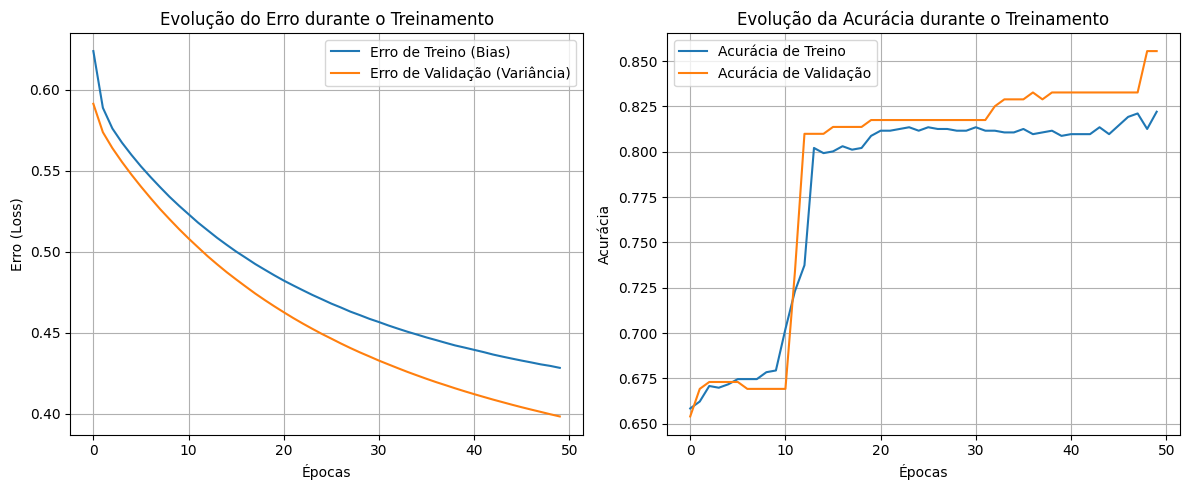

In [26]:
plt.figure(figsize=(12, 5))

# Gráfico 1: Erro (loss) de treino e validação
plt.subplot(1, 2, 1)
plt.plot(historico1.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico1.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

# Gráfico 2: Acurácia de treino e validação
plt.subplot(1, 2, 2)
plt.plot(historico1.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico1.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Iniciando a busca pelo modelo, agora com uma camada oculta

In [27]:
model_one_hidden_layer1 = Sequential()
model_one_hidden_layer1.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model_one_hidden_layer1.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.01)
model_one_hidden_layer1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
historico2 = model_one_hidden_layer1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [29]:
train_loss, train_accuracy = model_one_hidden_layer1.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_one_hidden_layer1.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3851 | Acurácia de treino: 0.8392
Erro de teste (variância): 0.3367 | Acurácia de teste: 0.8593


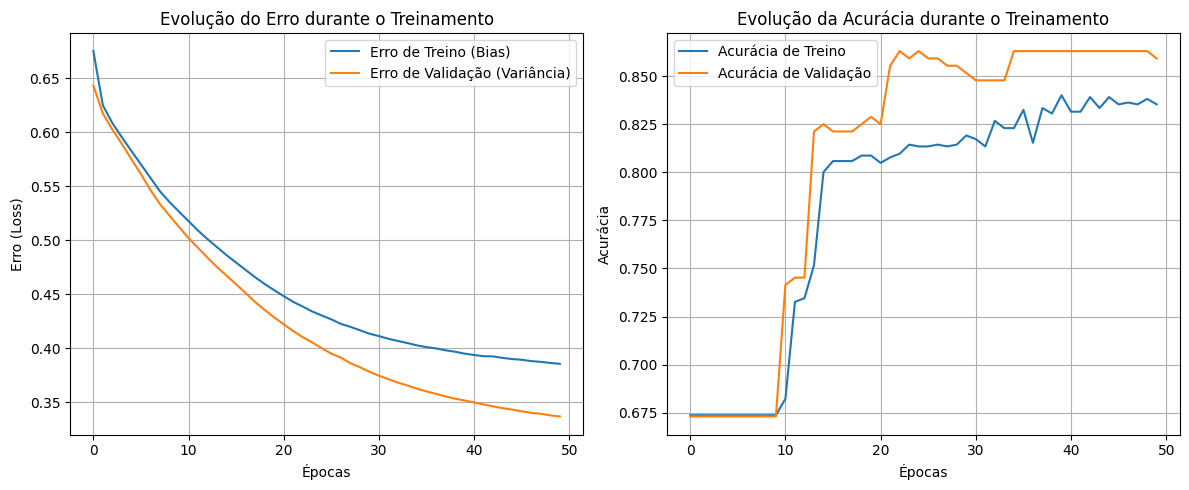

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico2.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico2.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico2.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico2.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
model_one_hidden_layer2 = Sequential()
model_one_hidden_layer2.add(Dense(40, input_dim=X_train.shape[1], activation='relu'))
model_one_hidden_layer2.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.01)
model_one_hidden_layer2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
historico3 = model_one_hidden_layer2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [33]:
train_loss, train_accuracy = model_one_hidden_layer2.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_one_hidden_layer2.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3847 | Acurácia de treino: 0.8354
Erro de teste (variância): 0.3370 | Acurácia de teste: 0.8517


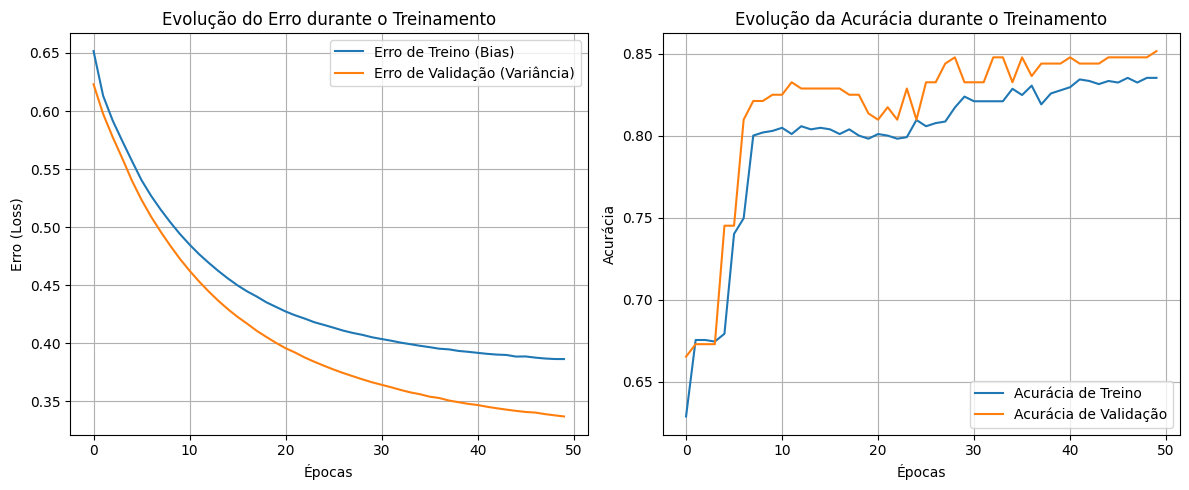

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico3.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico3.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico3.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico3.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
model_one_hidden_layer3 = Sequential()
model_one_hidden_layer3.add(Dense(80, input_dim=X_train.shape[1], activation='relu'))
model_one_hidden_layer3.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.01)
model_one_hidden_layer3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
historico4 = model_one_hidden_layer3.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [37]:
train_loss, train_accuracy = model_one_hidden_layer3.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_one_hidden_layer3.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3795 | Acurácia de treino: 0.8363
Erro de teste (variância): 0.3263 | Acurácia de teste: 0.8631


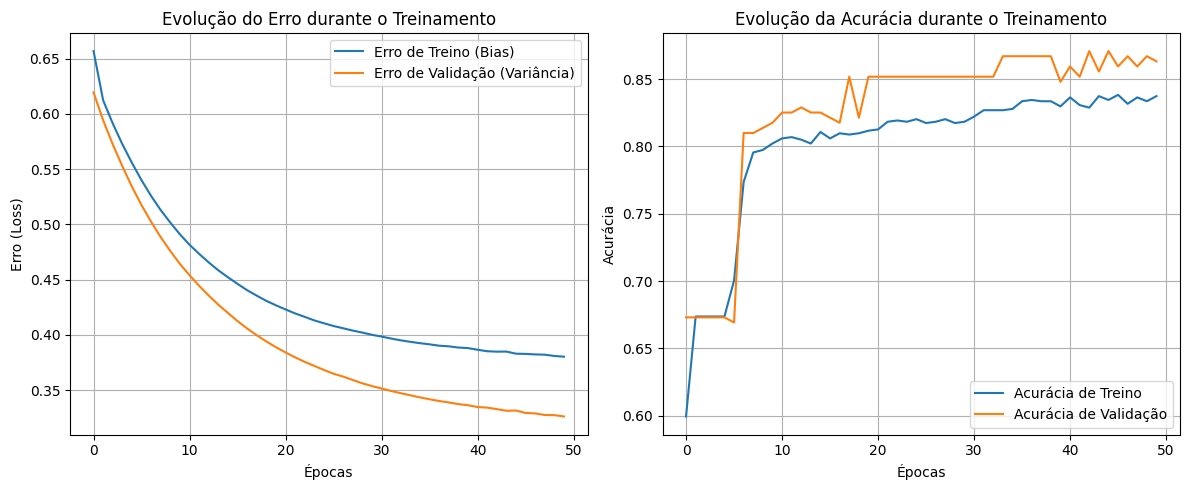

In [38]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico4.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico4.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico4.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico4.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Para agilizar o processo, é utilizado o optuna que irá fazer vários testes para descobrir quais os melhores hiperparâmetros entre o número de neuronios e o valor do learning rate

In [39]:
warnings.filterwarnings("ignore")

def objective(trial):
    # Hiperparâmetros a serem otimizados
    n_neurons = trial.suggest_int("n_neurons", 8, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)

    model = Sequential()

    model.add(Dense(n_neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = SGD(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,batch_size=32,verbose=0)

    trial.set_user_attr("history", history)

    return max(history.history['val_accuracy'])

# Rodar a otimização
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Pegar o melhor histórico para poder plotar depois
best_trial = study.best_trial
history = best_trial.user_attrs["history"]

print("Melhores hiperparâmetros encontrados:", study.best_params)
print("Melhor acurácia de validação:", study.best_value)

[I 2025-05-15 15:21:25,602] A new study created in memory with name: no-name-3c3b21d2-217a-41b6-a3cd-fbab0ec97d48
[I 2025-05-15 15:21:31,400] Trial 0 finished with value: 0.8707224130630493 and parameters: {'n_neurons': 106, 'lr': 0.061623966947040046}. Best is trial 0 with value: 0.8707224130630493.
[I 2025-05-15 15:21:36,340] Trial 1 finished with value: 0.8631178736686707 and parameters: {'n_neurons': 55, 'lr': 0.02308919987705487}. Best is trial 0 with value: 0.8707224130630493.
[I 2025-05-15 15:21:44,699] Trial 2 finished with value: 0.6692014932632446 and parameters: {'n_neurons': 118, 'lr': 0.0003190455184240294}. Best is trial 0 with value: 0.8707224130630493.
[I 2025-05-15 15:21:51,039] Trial 3 finished with value: 0.8707224130630493 and parameters: {'n_neurons': 93, 'lr': 0.07260243024186291}. Best is trial 0 with value: 0.8707224130630493.
[I 2025-05-15 15:21:57,902] Trial 4 finished with value: 0.8098859190940857 and parameters: {'n_neurons': 21, 'lr': 0.008973743260804516}

Melhores hiperparâmetros encontrados: {'n_neurons': 81, 'lr': 0.0906292577144766}
Melhor acurácia de validação: 0.8859315514564514


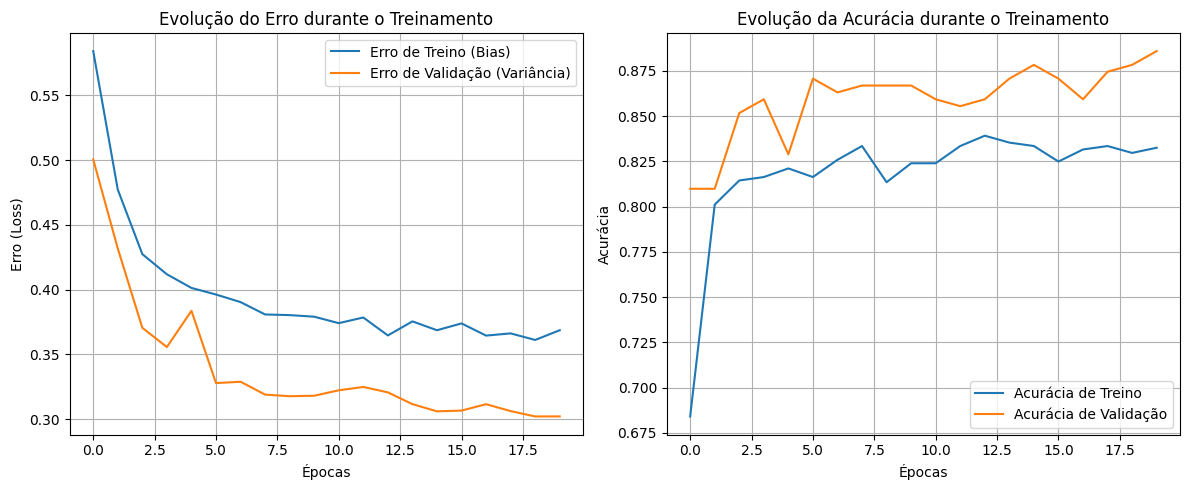

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Erro de Treino (Bias)')
plt.plot(history.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Iniciando a busca pelo modelo, agora com duas camadas ocultas
Usamos os valores obtidos pelos testes com optuna como base para se iniciar esse processo

In [41]:
model_two_hidden_layer1 = Sequential()
model_two_hidden_layer1.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_two_hidden_layer1.add(Dense(20, activation='relu'))
model_two_hidden_layer1.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.09)
model_two_hidden_layer1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
historico5 = model_two_hidden_layer1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [43]:
train_loss, train_accuracy = model_two_hidden_layer1.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_two_hidden_layer1.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.2897 | Acurácia de treino: 0.8735
Erro de teste (variância): 0.2822 | Acurácia de teste: 0.8669


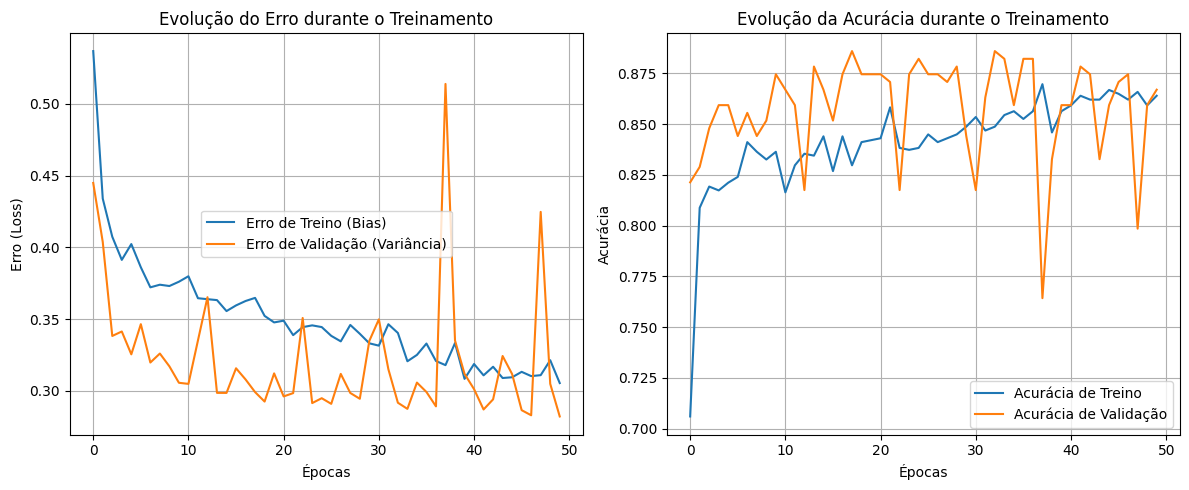

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico5.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico5.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico5.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico5.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [45]:
model_two_hidden_layer2 = Sequential()
model_two_hidden_layer2.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_two_hidden_layer2.add(Dense(40, activation='relu'))
model_two_hidden_layer2.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.09)
model_two_hidden_layer2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
historico6 = model_two_hidden_layer2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [47]:
train_loss, train_accuracy = model_two_hidden_layer2.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_two_hidden_layer2.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3051 | Acurácia de treino: 0.8582
Erro de teste (variância): 0.2960 | Acurácia de teste: 0.8669


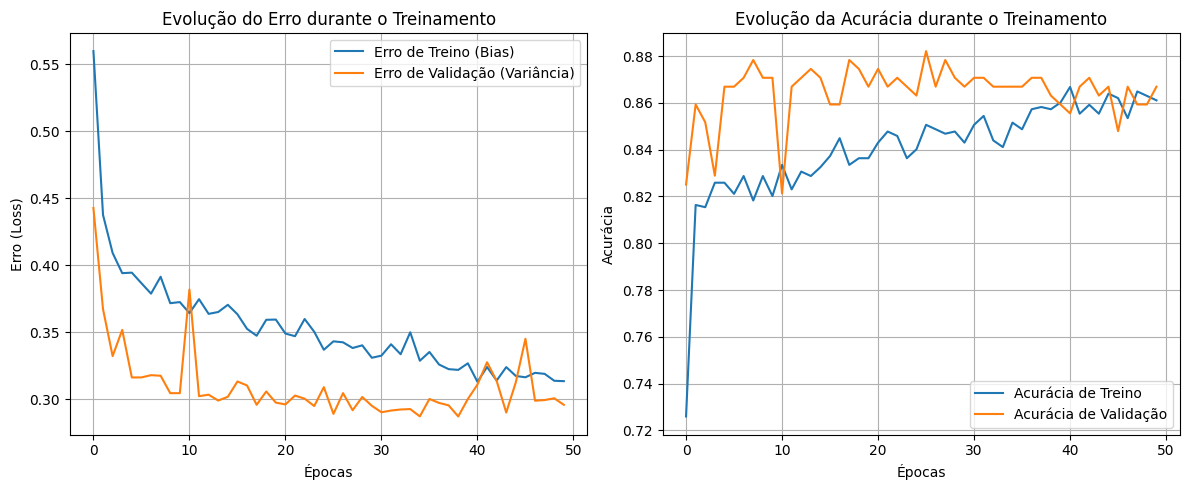

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico6.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico6.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico6.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico6.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Usando novamente o optuna,agora no caso de duas camadas ocultas e apenas para identificar o número de neurônios

In [49]:
warnings.filterwarnings("ignore")

def objective(trial):
    n_neurons = trial.suggest_int("n_neurons", 20, 128)

    model = Sequential()

    model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = SGD(learning_rate=0.09)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    history2 = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,batch_size=32,verbose=0)

    trial.set_user_attr("history", history)

    return max(history2.history['val_accuracy'])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_trial = study.best_trial
history2 = best_trial.user_attrs["history"]

print("Melhores hiperparâmetros encontrados:", study.best_params)
print("Melhor acurácia de validação:", study.best_value)

[I 2025-05-15 15:24:59,488] A new study created in memory with name: no-name-f7a5dd09-5b59-4198-b347-532b5e03627c
[I 2025-05-15 15:25:06,224] Trial 0 finished with value: 0.8783270120620728 and parameters: {'n_neurons': 90}. Best is trial 0 with value: 0.8783270120620728.
[I 2025-05-15 15:25:11,802] Trial 1 finished with value: 0.8821292519569397 and parameters: {'n_neurons': 53}. Best is trial 1 with value: 0.8821292519569397.
[I 2025-05-15 15:25:20,368] Trial 2 finished with value: 0.8821292519569397 and parameters: {'n_neurons': 27}. Best is trial 1 with value: 0.8821292519569397.
[I 2025-05-15 15:25:27,197] Trial 3 finished with value: 0.8783270120620728 and parameters: {'n_neurons': 86}. Best is trial 1 with value: 0.8821292519569397.
[I 2025-05-15 15:25:34,080] Trial 4 finished with value: 0.8859315514564514 and parameters: {'n_neurons': 43}. Best is trial 4 with value: 0.8859315514564514.
[I 2025-05-15 15:25:40,755] Trial 5 finished with value: 0.8783270120620728 and parameters:

Melhores hiperparâmetros encontrados: {'n_neurons': 43}
Melhor acurácia de validação: 0.8859315514564514


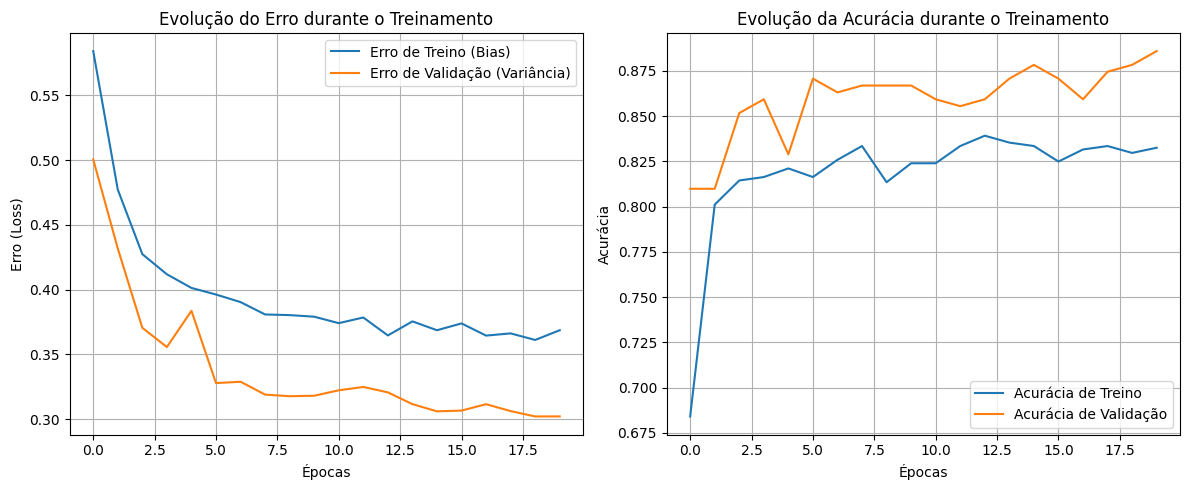

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Erro de Treino (Bias)')
plt.plot(history2.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Acurácia de Treino')
plt.plot(history2.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [51]:
model_two_hidden_layer3 = Sequential()
model_two_hidden_layer3.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_two_hidden_layer3.add(Dense(88, activation='relu'))
model_two_hidden_layer3.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.09)
model_two_hidden_layer3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
historico7 = model_two_hidden_layer3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [53]:
train_loss, train_accuracy = model_two_hidden_layer3.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_two_hidden_layer3.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3344 | Acurácia de treino: 0.8440
Erro de teste (variância): 0.2971 | Acurácia de teste: 0.8783


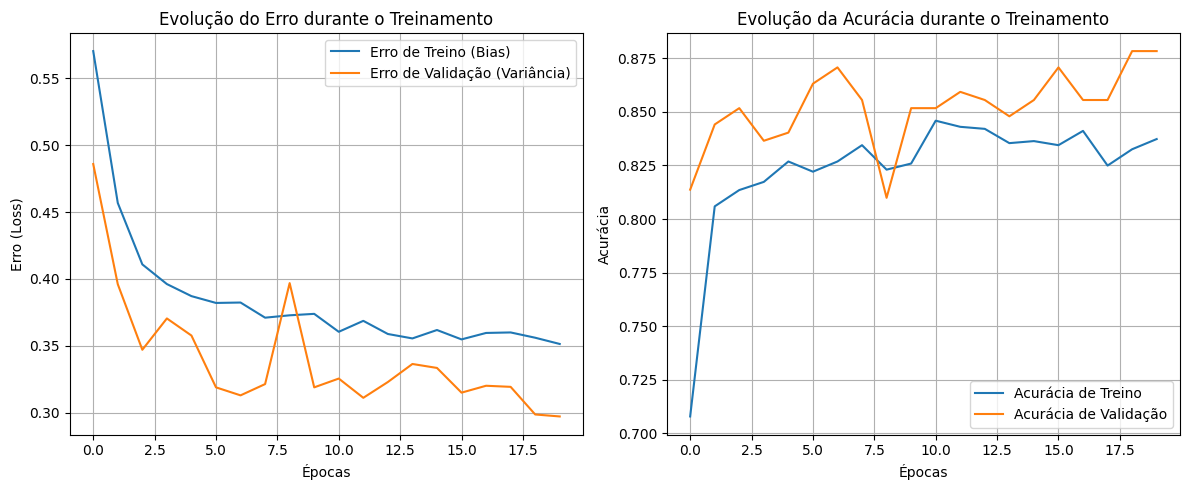

In [54]:
plt.figure(figsize=(12, 5))

# Gráfico 1: Erro (loss) de treino e validação
plt.subplot(1, 2, 1)
plt.plot(historico7.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico7.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

# Gráfico 2: Acurácia de treino e validação
plt.subplot(1, 2, 2)
plt.plot(historico7.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico7.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Agora o modelo com 3 camadas ocultas

In [55]:
model_three_hidden_layer1 = Sequential()
model_three_hidden_layer1.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_three_hidden_layer1.add(Dense(88, activation='relu'))
model_three_hidden_layer1.add(Dense(40, activation='relu'))
model_three_hidden_layer1.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.09)
model_three_hidden_layer1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
historico8 = model_three_hidden_layer1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [57]:
train_loss, train_accuracy = model_three_hidden_layer1.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_three_hidden_layer1.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3172 | Acurácia de treino: 0.8611
Erro de teste (variância): 0.2895 | Acurácia de teste: 0.8783


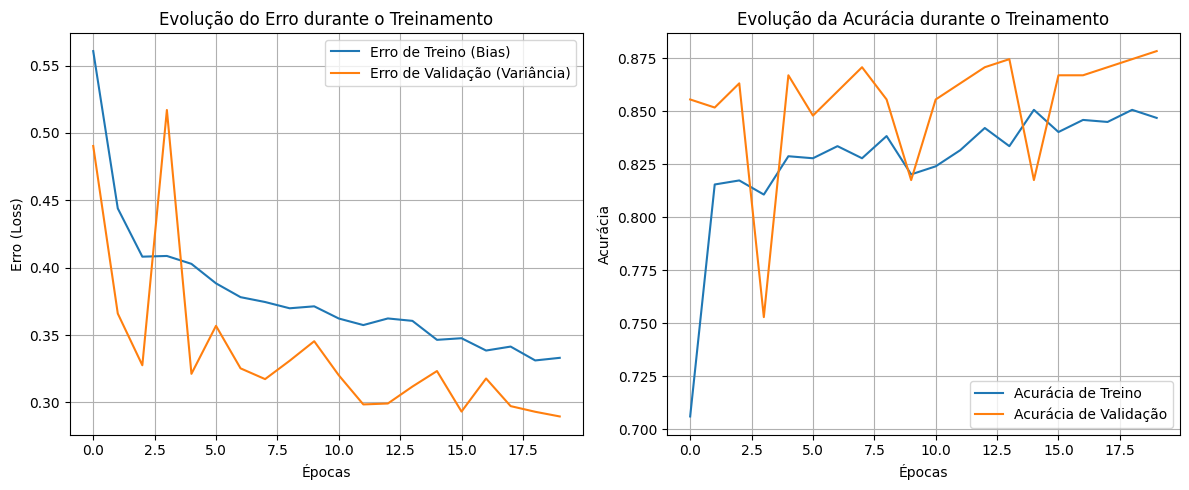

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico8.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico8.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico8.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico8.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [59]:
model_three_hidden_layer2 = Sequential()
model_three_hidden_layer2.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_three_hidden_layer2.add(Dense(88, activation='relu'))
model_three_hidden_layer2.add(Dense(80, activation='relu'))
model_three_hidden_layer2.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.09)
model_three_hidden_layer2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
historico9 = model_three_hidden_layer2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [61]:
train_loss, train_accuracy = model_three_hidden_layer2.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_three_hidden_layer2.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3652 | Acurácia de treino: 0.8249
Erro de teste (variância): 0.3472 | Acurácia de teste: 0.8251


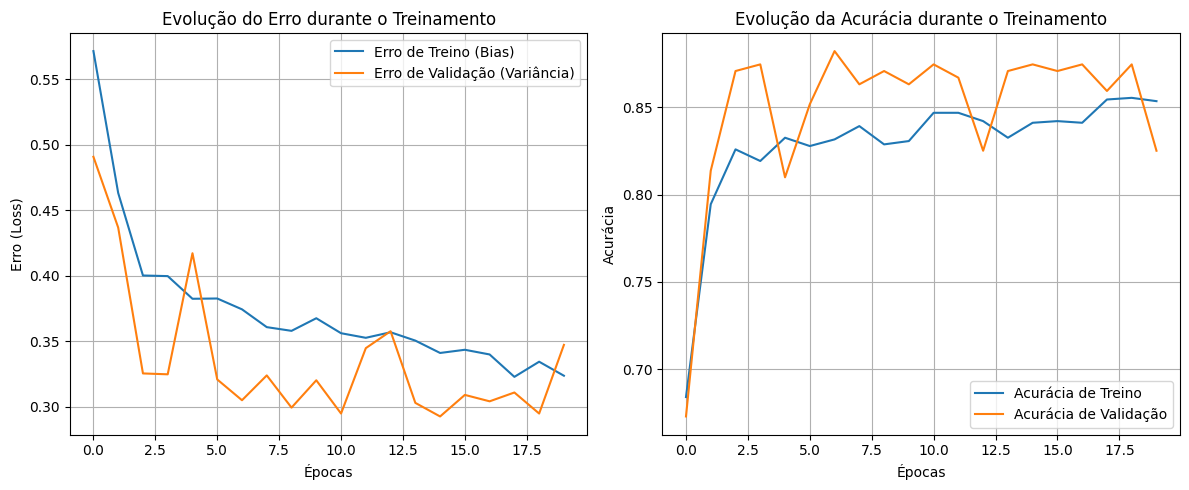

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico9.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico9.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico9.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico9.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Agrupando os resultados

Para facilitar a visualização dos resultados de cada modelo é exibido logo abaixo uma visão geral com todos os resultados obtidos com cada um dos modelos

In [63]:
train_loss, train_accuracy = model_no_hidden_layer.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_no_hidden_layer.evaluate(X_test, y_test, verbose=0)
print("\nmodel_no_hidden_layer")
print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")

train_loss1, train_accuracy1 = model_one_hidden_layer1.evaluate(X_train, y_train, verbose=0)
test_loss1, test_accuracy1 = model_one_hidden_layer1.evaluate(X_test, y_test, verbose=0)
print("\nmodel_one_hidden_layer1")
print(f"\nErro de treino (bias): {train_loss1:.4f} | Acurácia de treino: {train_accuracy1:.4f}")
print(f"Erro de teste (variância): {test_loss1:.4f} | Acurácia de teste: {test_accuracy1:.4f}")

train_loss2, train_accuracy2 = model_one_hidden_layer2.evaluate(X_train, y_train, verbose=0)
test_loss2, test_accuracy2 = model_one_hidden_layer2.evaluate(X_test, y_test, verbose=0)
print("\nmodel_one_hidden_layer2")
print(f"\nErro de treino (bias): {train_loss2:.4f} | Acurácia de treino: {train_accuracy2:.4f}")
print(f"Erro de teste (variância): {test_loss2:.4f} | Acurácia de teste: {test_accuracy2:.4f}")

train_loss3, train_accuracy3 = model_one_hidden_layer3.evaluate(X_train, y_train, verbose=0)
test_loss3, test_accuracy3 = model_one_hidden_layer3.evaluate(X_test, y_test, verbose=0)
print("\nmodel_one_hidden_layer3")
print(f"\nErro de treino (bias): {train_loss3:.4f} | Acurácia de treino: {train_accuracy3:.4f}")
print(f"Erro de teste (variância): {test_loss3:.4f} | Acurácia de teste: {test_accuracy3:.4f}")

train_loss4, train_accuracy4 = model_two_hidden_layer1.evaluate(X_train, y_train, verbose=0)
test_loss4, test_accuracy4 = model_two_hidden_layer1.evaluate(X_test, y_test, verbose=0)
print("\nmodel_two_hidden_layer1")
print(f"\nErro de treino (bias): {train_loss4:.4f} | Acurácia de treino: {train_accuracy4:.4f}")
print(f"Erro de teste (variância): {test_loss4:.4f} | Acurácia de teste: {test_accuracy4:.4f}")

train_loss5, train_accuracy5 = model_two_hidden_layer2.evaluate(X_train, y_train, verbose=0)
test_loss5, test_accuracy5 = model_two_hidden_layer2.evaluate(X_test, y_test, verbose=0)
print("\nmodel_two_hidden_layer2")
print(f"\nErro de treino (bias): {train_loss5:.4f} | Acurácia de treino: {train_accuracy5:.4f}")
print(f"Erro de teste (variância): {test_loss5:.4f} | Acurácia de teste: {test_accuracy5:.4f}")

train_loss6, train_accuracy6 = model_two_hidden_layer3.evaluate(X_train, y_train, verbose=0)
test_loss6, test_accuracy6 = model_two_hidden_layer3.evaluate(X_test, y_test, verbose=0)
print("\nmodel_two_hidden_layer3")
print(f"\nErro de treino (bias): {train_loss6:.4f} | Acurácia de treino: {train_accuracy6:.4f}")
print(f"Erro de teste (variância): {test_loss6:.4f} | Acurácia de teste: {test_accuracy6:.4f}")

train_loss7, train_accuracy7 = model_three_hidden_layer1.evaluate(X_train, y_train, verbose=0)
test_loss7, test_accuracy7 = model_three_hidden_layer1.evaluate(X_test, y_test, verbose=0)
print("\nmodel_three_hidden_layer1")
print(f"\nErro de treino (bias): {train_loss7:.4f} | Acurácia de treino: {train_accuracy7:.4f}")
print(f"Erro de teste (variância): {test_loss7:.4f} | Acurácia de teste: {test_accuracy7:.4f}")

train_loss8, train_accuracy8 = model_three_hidden_layer2.evaluate(X_train, y_train, verbose=0)
test_loss8, test_accuracy8 = model_three_hidden_layer2.evaluate(X_test, y_test, verbose=0)
print("\nmodel_three_hidden_layer2")
print(f"\nErro de treino (bias): {train_loss8:.4f} | Acurácia de treino: {train_accuracy8:.4f}")
print(f"Erro de teste (variância): {test_loss8:.4f} | Acurácia de teste: {test_accuracy8:.4f}")


model_no_hidden_layer

Erro de treino (bias): 0.4276 | Acurácia de treino: 0.8221
Erro de teste (variância): 0.3984 | Acurácia de teste: 0.8555

model_one_hidden_layer1

Erro de treino (bias): 0.3851 | Acurácia de treino: 0.8392
Erro de teste (variância): 0.3367 | Acurácia de teste: 0.8593

model_one_hidden_layer2

Erro de treino (bias): 0.3847 | Acurácia de treino: 0.8354
Erro de teste (variância): 0.3370 | Acurácia de teste: 0.8517

model_one_hidden_layer3

Erro de treino (bias): 0.3795 | Acurácia de treino: 0.8363
Erro de teste (variância): 0.3263 | Acurácia de teste: 0.8631

model_two_hidden_layer1

Erro de treino (bias): 0.2897 | Acurácia de treino: 0.8735
Erro de teste (variância): 0.2822 | Acurácia de teste: 0.8669

model_two_hidden_layer2

Erro de treino (bias): 0.3051 | Acurácia de treino: 0.8582
Erro de teste (variância): 0.2960 | Acurácia de teste: 0.8669

model_two_hidden_layer3

Erro de treino (bias): 0.3344 | Acurácia de treino: 0.8440
Erro de teste (variância): 0.2971 |

In [78]:
df

,has_domain,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,access_to_closed_profile,...,city_grouped_Kostomuksha,city_grouped_Krasnodar,city_grouped_Moscow,city_grouped_Murmansk,city_grouped_New York City,city_grouped_Nizhny Novgorod,city_grouped_Other,city_grouped_Perm,city_grouped_Petrozavodsk,city_grouped_Saint Petersburg
0,1.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
1,1.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
2,1.0,0.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,0.0,...,False,False,False,False,False,False,True,False,False,False
3,1.0,1.0,0.0,1.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
4,1.0,1.0,0.0,1.0,0.13562,1.0,1.0,1.0,1.0,0.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,1.0,1.0,0.0,0.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,True
1310,1.0,1.0,0.0,1.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
1311,1.0,1.0,0.0,1.0,0.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
1312,1.0,1.0,0.0,1.0,1.00000,1.0,1.0,1.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False


In [77]:
df.columns

Index(['has_domain', 'has_photo', 'can_post_on_wall', 'can_send_message',
       'has_website', 'gender', 'has_short_name', 'has_first_name',
       'has_last_name', 'access_to_closed_profile', 'is_profile_closed',
       'target', 'has_nickname', 'has_mobile', 'all_posts_visible',
       'audio_available', 'can_add_as_friend', 'can_invite_to_group',
       'is_verified', 'is_confirmed', 'has_domain_missing',
       'has_photo_missing', 'gender_missing', 'has_short_name_missing',
       'can_post_on_wall_missing', 'can_send_message_missing',
       'has_last_name_missing', 'has_first_name_missing',
       'is_profile_closed_missing', 'access_to_closed_profile_missing',
       'city_grouped_Kostomuksha', 'city_grouped_Krasnodar',
       'city_grouped_Moscow', 'city_grouped_Murmansk',
       'city_grouped_New York City', 'city_grouped_Nizhny Novgorod',
       'city_grouped_Other', 'city_grouped_Perm', 'city_grouped_Petrozavodsk',
       'city_grouped_Saint Petersburg'],
      dtype='obje

In [80]:
df.iloc[0]

,0
has_domain,1.0
has_photo,0.0
can_post_on_wall,0.0
can_send_message,0.0
has_website,0.0
gender,1.0
has_short_name,1.0
has_first_name,1.0
has_last_name,1.0
access_to_closed_profile,1.0


In [81]:
# prompt: gere uma array para eu testar o modelo

# Generate a sample array with the same number of features as the training data
# and based on the first row of the dataframe.
import numpy as np

# Get the first row of the processed dataframe
sample_data = df.iloc[0].drop('target')

# Convert the sample data to a numpy array and reshape it for prediction
sample_array = np.array(sample_data).reshape(1, -1)

print("Generated sample array shape:", sample_array.shape)
print("Generated sample array:", sample_array)


Generated sample array shape: (1, 39)
Generated sample array: [[np.float64(1.0) np.float64(0.0) np.float64(0.0) np.float64(0.0)
  np.float64(0.0) np.float64(1.0) np.float64(1.0) np.float64(1.0)
  np.float64(1.0) np.float64(1.0) np.float64(0.0)
  np.float64(0.05485232067510549) np.float64(0.9511754068716094)
  np.float64(0.33755274261603374) np.float64(0.41621458710066306)
  np.float64(0.8725135623869801) np.float64(0.12055455093429777)
  np.float64(0.03345388788426763) np.float64(0.0003013863773357444)
  np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0)
  np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.False_ np.False_
  np.False_ np.False_ np.False_ np.False_ np.True_ np.False_ np.False_
  np.False_]]


In [91]:
# Gera um array de exemplo com o mesmo número de atributos dos dados de treino,baseado na primeira linha do DataFrame.

# Obtém a primeira linha do DataFrame processado e remove a coluna 'target'
amostra_dados = df.iloc[0].drop('target')

# Converte os dados da amostra para um array NumPy e redimensiona para predição
# Garante que o array tenha tipo numérico, por exemplo, float32
# Se df.dtypes indicar colunas do tipo 'object', é necessário tratá-las
# (por exemplo, removê-las, codificá-las ou convertê-las para numérico) ANTES de criar a amostra
amostra_array = np.array(amostra_dados).reshape(1, -1).astype(np.float32)

print("Formato do array de amostra gerado:", amostra_array.shape)
print("Array de amostra gerado:", amostra_array)

# Realiza a predição
probabilidade = model_three_hidden_layer1.predict(amostra_array)

# Converte a probabilidade em classe (0 ou 1) com base no limiar de 0.5
classe_predita = (probabilidade > 0.5).astype(int)

print("Probabilidade da classe positiva:", probabilidade[0][0])
print("Classe predita:", classe_predita[0][0])
print("Classe real:", df.iloc[0]['target'])


Formato do array de amostra gerado: (1, 39)
Array de amostra gerado: [[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
  0.0000000e+00 5.4852322e-02 9.5117539e-01 3.3755276e-01 4.1621459e-01
  8.7251353e-01 1.2055455e-01 3.3453889e-02 3.0138638e-04 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Probabilidade da classe positiva: 0.9185744
Classe predita: 1
Classe real: 1


#Utilizando o momentum
Selecionamos o melhor modelo encontrado e adicionamos o momentum na parte do processo de aprendizagem para verificar o resultado

In [64]:
model_momentum = Sequential()
model_momentum.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_momentum.add(Dense(88, activation='relu'))
model_momentum.add(Dense(40, activation='relu'))
model_momentum.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.09,momentum=0.9)
model_momentum.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
historico9 = model_momentum.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [66]:
train_loss, train_accuracy = model_momentum.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_momentum.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.3392 | Acurácia de treino: 0.8221
Erro de teste (variância): 0.3353 | Acurácia de teste: 0.8175


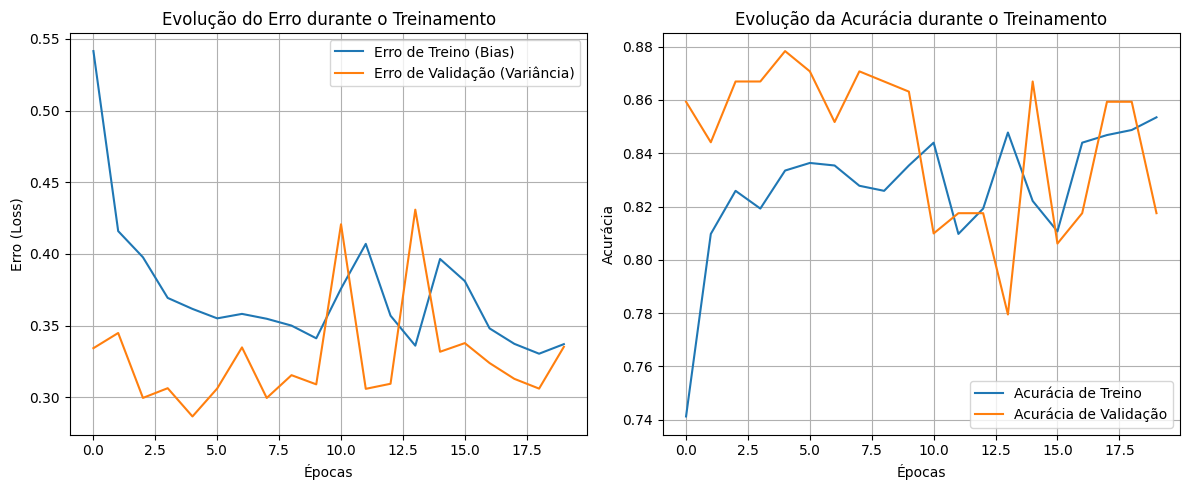

In [67]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico9.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico9.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico9.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico9.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Assim, utilizando o momentum é possível observar uma melhora no processo de aprendizagem do modelo,contribuindo para erros menores. Na parte de validação, o erro já começa bem mais baixo do que sem momentum, com uma diferença de mais de 10%, culminando em uma acurácia que já inicia mais elevada tambem

#EXTRA,apenas por curiosidade
utilizando como otimizador o adam e não mais o SGD

In [68]:
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2  # para L2 regularization

model_adam = Sequential()
model_adam.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_adam.add(Dense(88, activation='relu'))
model_adam.add(Dense(40, activation='relu'))
model_adam.add(Dense(1, activation='sigmoid'))

model_adam.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
historico10 = model_adam.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),verbose=0)

In [70]:
train_loss, train_accuracy = model_adam.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_adam.evaluate(X_test, y_test, verbose=0)

print(f"\nErro de treino (bias): {train_loss:.4f} | Acurácia de treino: {train_accuracy:.4f}")
print(f"Erro de teste (variância): {test_loss:.4f} | Acurácia de teste: {test_accuracy:.4f}")


Erro de treino (bias): 0.2614 | Acurácia de treino: 0.8801
Erro de teste (variância): 0.2861 | Acurácia de teste: 0.8631


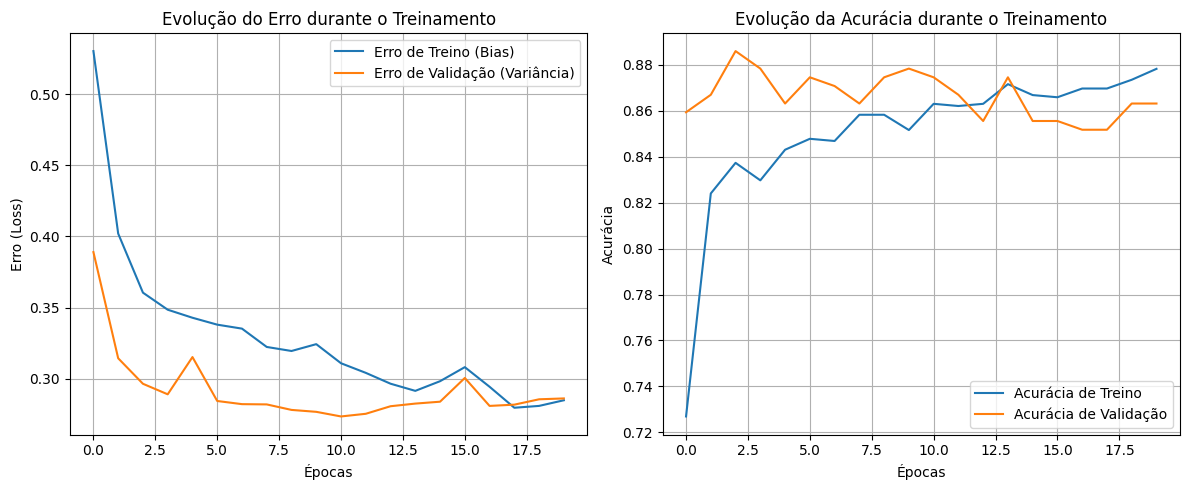

In [71]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico10.history['loss'], label='Erro de Treino (Bias)')
plt.plot(historico10.history['val_loss'], label='Erro de Validação (Variância)')
plt.title('Evolução do Erro durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historico10.history['accuracy'], label='Acurácia de Treino')
plt.plot(historico10.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Comparando com outros métodos ( Arvore de decisão, Random Forest e Catboost)

In [72]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

In [74]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Previsão
y_pred = clf.predict(X_test)

# Avaliação
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.4f}")

Acurácia: 0.8479


In [75]:
rf_model = RandomForestClassifier(
    n_estimators=100,       # número de árvores
    max_depth=10,           # profundidade máxima da árvore
    random_state=42         # para reprodutibilidade
)
rf_model.fit(X_train, y_train)

# Previsão
y_pred = rf_model.predict(X_test)

# Avaliação
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.4f}")

Acurácia: 0.8517


In [76]:
cat_model = CatBoostClassifier(
    iterations=500,       # número de árvores
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,          # imprime a cada 100 iterações
    random_seed=42
)

# Treinamento
cat_model.fit(X_train, y_train)

# Previsão
y_pred = cat_model.predict(X_test)

# Avaliação
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.4f}")

0:	learn: 0.6225947	total: 47.9ms	remaining: 23.9s
100:	learn: 0.2651730	total: 195ms	remaining: 770ms
200:	learn: 0.2367531	total: 331ms	remaining: 493ms
300:	learn: 0.2171014	total: 467ms	remaining: 308ms
400:	learn: 0.2089133	total: 662ms	remaining: 163ms
499:	learn: 0.2034010	total: 910ms	remaining: 0us
Acurácia: 0.8403


Com isso, para fim de comparação, é possível testificar que o modelo criado bate os resultados obtidos pelos modelos clássicos, conseguindo acurácia superior

#Visão Geral

Passando por todas as etapas desse processo, temos uma base de dados e uma ideia que é identificar se um usuário é um ser humano ou um bot, de começo há a necessidade de tratar a base de dados, pois ela conta com diversos valores faltando, sendo que há atributos com mais da metade dos dados faltando. Então é retirado certos atributos e alguns dados artificiais são colocados para preencher os vazios, também foi feito algumas manipulações devido ao formato dos dados. Após isso se deu início a parte da criação dos modelos, nessa etapa foi-se aumentando o número de neurônios ou o número de camadas ocultas do modelo,visando encontrar um modelo que obtesse melhor resultado, para isso também foi utilizado a biblioteca optuna para facilitar a busca dos melhores hiperparâmetros. Após treinar todos os modelos, sempre analisando os gráficos também das curvas de erro e acurácia,tanto no treino como já validação, foi obtido os resultados finais. O modelo que obteve a maior acurácia foi o modelo com 3 camadas ocultas(com 40 neurônios na última camada),chegando a uma acurácia de 87,4%, também há o modelo com 2 camadas ocultas(com 40 neurônios na última camada) que chegou a 86,69% de acurácia. Após isso, foi testado o melhor modelo,mas agora utilizando o momentum, com isso,é observado nos gráficos um aprendizado ligeiramente mais rápido devido a presença dessa técnica,chegando aos resultados de forma mais rápida. Por fim,para fim de comparação, foi usado alguns modelos clássicos: Árvore de Decisão, Random Forest e Catboost. O melhor resultado entre eles ficou por volta de 85% de acurácia. Dessa forma, o modelo MLP criado foi superior aos modelos clássicos, demonstrando sua eficácia.